定义求导和KNN分类器

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
import math

data_train = np.array(pd.read_csv(r'train_data.csv'))
data_test = np.array(pd.read_csv(r'test_data.csv'))
data_val = np.array(pd.read_csv(r'val_data.csv'))

train_mean=np.zeros((5,1))
train_sigma=np.ones((5,1))
for i in range(4):
    train_mean[i]=np.mean(data_train[:,i])
    train_sigma[i]=np.std(data_train[:,i])
data_train=(data_train-train_mean.T)/train_sigma.T
data_val=(data_val-train_mean.T)/train_sigma.T

N=10#训练轮次
fa=np.zeros((N,1))


def KNN_M(k,A):#k值，矩阵A
    if (k % 2) == 0:#只取奇数
        return 0
    result=np.zeros((data_val.shape[0],1))
    for i in range(0,data_val.shape[0]):
        distance = np.zeros((data_train.shape[0],2))#计算待测点和训练集所有点的距离
        for j in range(0,data_train.shape[0]):
            distance[j,0]=np.linalg.norm(np.dot(A,(data_val[i,0:4]-data_train[j,0:4]).reshape(4,1)))#马氏距离
        distance[:,1]=range(data_train.shape[0])
        a=np.lexsort(distance.T[:1,:])#排序后获取在原数组中的位置
        sort=distance[a,:]
        count1=0#属于类别1的个数
        count0=0#属于类别0的个数
        for j in range(k):
            if data_train[int(sort[j,1]),4]==1:
                count1=count1+1
            else:
                count0=count0+1
        for n in range(1,10):
            if sort[n+j,0]!=sort[j,0]:#考察在近邻边界上是否有重叠的点
                break#没有，退出
            else:
                if data_train[int(sort[n+j,1]),4]==1:
                    count1=count1+1
                else:
                    count0=count0+1

        if count1>count0:#选择数量占多数的类别
            result[i]=1

    correct=0
    for i in range(0,data_val.shape[0]):
        if result[i,0]==data_val[i,4]:
            correct=correct+1
    return correct/data_val.shape[0]

def A_learn(A,epoch,lr):
    distance2=np.zeros((data_train.shape[0],data_train.shape[0]))
    for i in range(data_train.shape[0]):
        for j in range(data_train.shape[0]):
            dx=(data_train[i,0:4]-data_train[j,0:4]).reshape(4,1)
            distance2[i,j]=np.dot(np.dot(dx.T,A.T),np.dot(A,dx))

    exp_dis=np.exp(-distance2)
    pi=np.zeros((data_train.shape[0],1))
    pij=np.zeros((data_train.shape[0],data_train.shape[0]))
    for i in range(data_train.shape[0]):
        for j in range(data_train.shape[0]):
            pij[i,j]=exp_dis[i,j]/(sum(exp_dis[i,:])-exp_dis[i,i])
        pij[i,i]=0
        for j in range(data_train.shape[0]):
            if data_train[i,4]==data_train[j,4]:
                pi[i,0]=pi[i,0]+pij[i,j]
    
    W=np.zeros((data_train.shape[0],data_train.shape[0]))
    for i in range(data_train.shape[0]):
        for j in range(data_train.shape[0]):
            if data_train[i,4]==data_train[j,4]:
                W[i,j]=(pi[i,0]-1)*pij[i,j]
            else:
                W[i,j]=pi[i,0]*pij[i,j] 
    X=data_train[:,0:4]
    grad=2*np.dot(np.dot(np.dot(X,A.T).T,(W.sum(axis=0)-W-W.T)),X)
    A=A+grad*lr
        #dp=-2*np.dot(A,dp)
        #A=A-2*lr*np.dot(A,dp)
    f=0
    for i in range(data_train.shape[0]):
        for j in range(data_train.shape[0]):
            if data_train[i,4]==data_train[j,4]:
                f=f+pij[i,j]
        
    print("f(A)=",f)
    fa[epoch]=f
    return A


训练分类器

In [ ]:
epoch=N
lr=0.001
A=random.random(size=(2,4))
#A=np.ones((2,4))
A=A

KNN=np.zeros((N,1))
print("---------------------------------------------")
for i in range(epoch):
    print("epoch=",i,":")
    A=A_learn(A,i,lr)
    KNN[i]=KNN_M(1,A)
    print("accuracy=", KNN[i])
    print("---------------------------------------------")
    #print("accuracy=",Kn_NN_L(1,A))

    # print(A)

画图

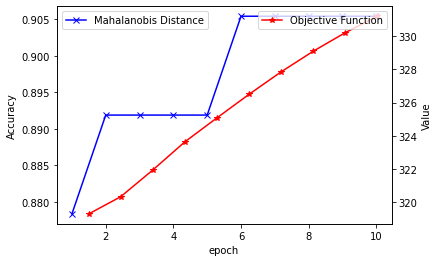

In [14]:

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
    
x=np.arange(1,N+1)
ax1.plot(x,KNN,marker='x',c='blue',label='Mahalanobis Distance')
ax2.plot(x,fa,marker='*',c='red',label='Objective Function')
x_tick = np.linspace(0,N,6)
ax1.set_xlabel("epoch")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Value")
plt.xticks(x_tick)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
#plt.ylim(31,34)
f = plt.gcf()  #获取当前图像
f.savefig(r'mission21.png',dpi=600)
plt.show()

In [33]:
print(A)
np.savetxt('A.csv',A)

[[1.03292395 0.05934473 0.10472689 0.59905512]
 [0.82038977 0.78978521 0.17499995 0.70298866]]


预测测试集上的分类结果

In [47]:
def KNN_pred(k,A,data_val):#k值，矩阵A
    if (k % 2) == 0:#只取奇数
        return 0
    result=np.zeros((data_val.shape[0],1))
    for i in range(0,data_val.shape[0]):
        distance = np.zeros((data_train.shape[0],2))#计算待测点和训练集所有点的距离
        for j in range(0,data_train.shape[0]):
            distance[j,0]=np.linalg.norm(np.dot(A,(data_val[i,0:4]-data_train[j,0:4]).reshape(4,1)))#马氏距离
        distance[:,1]=range(data_train.shape[0])
        a=np.lexsort(distance.T[:1,:])#排序后获取在原数组中的位置
        sort=distance[a,:]
        count1=0#属于类别1的个数
        count0=0#属于类别0的个数
        for j in range(k):
            if data_train[int(sort[j,1]),4]==1:
                count1=count1+1
            else:
                count0=count0+1
        for n in range(1,10):
            if sort[n+j,0]!=sort[j,0]:#考察在近邻边界上是否有重叠的点
                break#没有，退出
            else:
                if data_train[int(sort[n+j,1]),4]==1:
                    count1=count1+1
                else:
                    count0=count0+1

        if count1>count0:#选择数量占多数的类别
            result[i]=1

    return result

In [62]:
data_test2=np.zeros(data_test.shape)
for i in range(4):
    data_test2[:,i]=(data_test[:,i]-train_mean[i])/train_sigma[i]
pred = KNN_pred(1,A,data_test2)
prediction=np.c_[data_test,pred]
prediction=prediction.astype(np.uint16)
sample={
    'Recency (months)':prediction[:,0],
    'Frequency (times)':prediction[:,1],
    'Monetary (c.c. blood)':prediction[:,2],
    'Time (months)':prediction[:,3],
    'My prediction':prediction[:,4],
}
pd.DataFrame(sample).to_csv('task2_test_ prediction.csv',index=False)